In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
math.sqrt(512)

22.627416997969522

In [3]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.pre_embed = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    
    def forward(self, x):
        # 약 22를 곱해서 임베딩 값을 뻥튀기 시킨다.
        # 포지션 벡터로인해 결과가 희석되는 것을 막기 위함(?)
        return self.pre_embed(x) * math.sqrt(self.d_model)

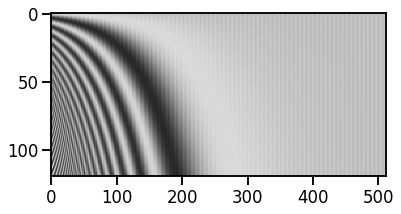

In [4]:
seq_length = 120
d_model =512

PE = np.zeros((seq_length, d_model))

for pos in range(seq_length):
    for i in range(d_model //2):
        PE[pos, 2*i] = np.sin( pos / (10000 ** (2*i / d_model)))
        PE[pos, 2*i+1] = np.cos( pos / (10000 ** (2*i / d_model)))

plt.figure(figsize = (6,3))
plt.imshow(PE, aspect='auto', cmap='gray', interpolation='gaussian')
plt.show()


In [5]:
def pe_test(pos, i, d_model=512):
    PE = []
    PE.append( np.sin( pos / (10000**(2*i/d_model)) ) )
    PE.append( np.cos( pos / (10000**(2*i/d_model)) ) )

    return np.array(PE)

In [6]:
k = 10
d_model = 512
i = 1

pos1 = 100
pos1k = pos1 + k

pos2 = 172
pos2k = pos2 + k

M_k = np.array([[np.cos(k/(10000**(2*i/d_model))), np.sin(k/(10000**(2*i/d_model)))], 
                [-np.sin(k/(10000**(2*i/d_model))), np.cos(k/(10000**(2*i/d_model)))]])

pe_pos1 = pe_test(pos1, i)
pe_pos1k = pe_test(pos1k, i)
pe_pos2 = pe_test(pos2, i)
pe_pos2k = pe_test(pos2k, i)

print(f'pe at {pos1}:', pe_pos1)
print(f'pe at {pos1k}:', pe_pos1k)
print(f'linear transformation of pe at {pos1} by M:', np.dot(M_k, pe_pos1))

print(f'pe at {pos2}:', pe_pos2)
print(f'pe at {pos2k}:', pe_pos2k)
print(f'linear transformation of pe at {pos2} by M:', np.dot(M_k, pe_pos2))

pe at 100: [ 0.79754236 -0.60326294]
pe at 110: [-0.64526647  0.76395758]
linear transformation of pe at 100 by M: [-0.64526647  0.76395758]
pe at 172: [ 0.55020692 -0.83502835]
pe at 182: [-0.3529983   0.93562396]
linear transformation of pe at 172 by M: [-0.3529983   0.93562396]


In [7]:
class PositionalEncoding(nn.Module):
    "포지셔널 인코딩 실제 동작"
    def __init__(self, d_model, dropout, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)) *  -(math.log(10000.0)/ d_model)

        pe[ :, 0::2] = torch.sin(position * div_term)
        pe[ :, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # 업데이트를 하지 않는 일반 layer, 모델 parameter로 등록하지 않음.
        self.register_buffer('pe', pe)

    def forward(self, x):
        pe_val = self.pe[:, :x.size(1)]
        pe_val.requires_grad = False

        x = x + pe_val
        return self.dropout(x)

In [8]:
def attention (query, key, value, mask = None, dropout=None):

    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k)
    # scores: (n_batch, h, n_seq, n_seq)

    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9) # mask가 0인 곳이 맞아? scores==0으로 해야하지 않나

    p_attn = F.softmax(scores, dim =-1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    # matmul: (n_bathc, h, n_seq, d_v)
    return torch.matmul(p_attn, value) , p_attn

In [9]:
# 진짜 감탄스러운 Scaled dot product....

In [10]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [11]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):

        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h

        # Wq, Wk, Wv and Wo. 각각 h개 만들지 말고 d_model의 1/h로 나눈다.
        self.linears = clones(nn.Linear(d_model, d_model), 4)

        self.attn = None
        self.dropout  = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask = None):
        # query, key, value: (n_seq, d_model)

        if mask is not None:
            mask = mask.unsqueeze(1) # h차원에 차원 추가
        nbatches = query.size(0)

        query, key, value = \
            [linear(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
                for linear, x in zip(self.linears, (query, key, value))]
        # 위 라인이 실행되면 query, key, value는 각각 (n_batches, h, n_seq, d_k)가 된다.

        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # x:(n_batches, h, n_seq, d_v), self.attn:(n_batches, h, n_seq, n_seq)

        # non-contigous Tensor는 주소값 재배열 연산이 필요할 때 사용할 수 없음!
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        # x:(n_batches, n_seq, h*d_k)
        return self.linears[-1](x)

In [12]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [13]:
# 왜 배치정규화가 아닌 레이어정규화를 쓰는가!?: 패딩,긴 시퀀스 등 미니배치 사이즈를 크게 가져가지 못함
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        # torch.nn.LayerNorm()과 맞추기 위해 unbiased = False로
        std = x.std(-1, unbiased=False, keepdim=True)

        return self.a_2 * (x-mean) / (std + self.eps) + self.b_2

In [14]:
class SublayerConnection(nn.Module):
    """residual connection followed by a layer norm."""

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """Apply residual connection to any sublayer with the same size"""
        # sublayer: attn or ff 를 포워드 시키고 드랍아웃+레이어정규화
        return self.norm(x+self.dropout(sublayer(x)))

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()

        # MultiHeadedAttention
        self.self_attn = self_attn

        # PositionwiseFeedForward
        self.feed_forward = feed_forward

        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) 
        # lambda가 들어가는 이유: x, mask 동시에 받기 떄문에 x만 인자로 들어가기 위함.
        # 아직 이해가 잘 안되는 부분
        return self.sublayer[1](x, self.feed_forward)

In [16]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()

        # make_model: Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x 

# Decoder 시작

In [17]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    aubsequent_mask =np.triu(np.ones(attn_shape), k=1).astype('unit8')
    return torch.from_numpy(subsequent_mask) ==0

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        # self_attn: MultiheadedAttention
        # src_attn: 마찬가지로 멀티헤드어텐션이지만 크로스 어텐션

        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn # cross attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        # memory: Encoder로 부터 넘어온 인코딩(n_batches, n_seq, d_model)
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [19]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        
        return x

In [20]:
# 마지막 Generator
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [21]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [22]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):

    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    model = Transformer(

        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),

        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),

        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),

        Generator(d_model, tgt_vocab)
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# test

In [23]:
tmp_model = make_model(10, 10, 2)

In [ ]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src # src: (n_baTches, n_seq_src)
        self.src_mask = (src != pad).unsqueeze(-2) #(n_batches, 1, n_seq_src)
        if trg is not None:
            self.trg = trg[:,:-1]
            self.trg_y = trg[:,1:]
            self.trg_mask =self.make_std_mask(self, trg, pad) # (n_batches, n_seq_trg, n_seq_trg)
            self.ntokens = (self.trg != pad).data.sum()
    
    @staticmethod